# Simplified 'julia' code for "The modeling of urban races"

## Loading required modules

In [1]:
using Random
using Distributions
using CubicSplines
using Plots
using Random
using Distributions
using LinearAlgebra
Random.seed!(1234);

## All the settings are introduced in the following cells 

### Numerical model discretization parameters

In [2]:
racedistance=10000.0 #race length (in meters)
timestep=0.4 #time step for time discretized method (in seconds)
observertimestep=1.0 #time interval to save into memory (in seconds)
observernsteps=8080 # Number of steps saved into memory for Post-Processing
endtime=8080.0; #

### Mathematical model parameters

In [3]:
frontviewdistance=4.0 # Linear distance in front of the runner defining his vital space
minratio=15.0/40.0 #Min density (ratio of runners per area unit) 
maxratio=25.0/40.0 #Max density 
minrho=0.4 #Min value for rho
maxrho=0.8 #Max value for rho
posweights=[0.2 0; 2.0 30;  1.5 60;  1.25 120; 1.0 100000] # Parameters defining the metric
ldist=0.5; #Distance between rows at the starting position (in meters)

### Race settings

In [4]:
gap=180 # Time gap between consecutive waves
waves=[ 2333 500 500 0.0 3.34;
        500  2333 500 (214 +1*gap) 2.92;
        500 500 2334 (440.0+2*gap) 2.5]; # Waves mixture configuration 

### Course definition

In [5]:
trackname="track2"
trackdata=[-500.0 0.0 10.0;
          -400.0 0.0 10.0;
          -300.0 0.0 10.0;
          -200.0 0.0 10.0;
          -100.0 0.0 10.0;
          0.0 0.0 10.0;
          100.0 0.0 10.0;
          1000.0 10.0 10.0;
          2000.0 -2.0 5.0;
          2200.0 -2.0 3.0;
          2300.0 -1.0 3.0;
          2400.0 -1.0 3.0;
          2500.0 -1.0 6.0;
          3000.0 -15.0 10.0;
          4000.0 20.0 2.0;
          5000.0 -7.0 10.0;
          6000.0 9.0 10.0;
          7000.0 -10.0 10.0;
          8000.0 -1.0 7.0;
          9000.0 1.0 10.0;
          10000.0 0.0 10.0;
          10100.0 0.0 10.0;
          10200.0 0.0 10.0];

## Parameters and Tracks structures

In [6]:
struct Parameters
    timestep::Float32
    observertimestep::Float32
    observernsteps::Int16
    endtime::Float32
    waves::Matrix{Float32}
    frontviewdistance::Float32
    minratio::Float32
    maxratio::Float32
    minrho::Float32
    maxrho::Float32
    posweights::Matrix{Float32}
    ldist::Float32
    numberofwaves::Int8
    nrunners::Int16
    trackname::String
    trackdata::Matrix{Float32}
    racedistance::Float32
end

struct Tracks
    name::String
    x_data::Vector{Float32}
    diff_data::Vector{Float32}
    width_data::Vector{Float32}
    cspline_elev::CubicSplines.CubicSpline{Float32}
    cspline_width::CubicSplines.CubicSpline{Float32}
    foresightarea_data::Vector{Float32}
end

### Construct the Parameters structure

In [7]:
numberofwaves=size(waves)[1]
nrunners=Int(sum(waves[:,1:numberofwaves]))
parameters=Parameters(timestep,observertimestep,observernsteps, endtime,
               waves,frontviewdistance,minratio,maxratio,minrho,maxrho,
               posweights,ldist, numberofwaves, nrunners, trackname,trackdata,
               racedistance);

### Construct the Tracks structure

In [8]:
trackname=parameters.trackname
data=parameters.trackdata;
x_data=data[:,1]
diff_data=data[:,2]
width_data=data[:,3]
cspline_elev=CubicSpline(x_data,diff_data)
cspline_width=CubicSpline(x_data,width_data)

roadstart=0.0
roadend=floor(Int,parameters.racedistance)
roadbins= range(roadstart,roadend-1.0,ceil(Int,parameters.racedistance))
foresightarea_data=zeros(size(roadbins)[1])

for bin in roadbins
    h=parameters.frontviewdistance
    a=bin
    b=a+h
    wa=cspline_width(a)
    wb=cspline_width(b)
    foresightarea_data[floor(Int,bin)+1]=(wa+wb)*h/2.0
end


track=Tracks(trackname,x_data,diff_data,width_data,cspline_elev,cspline_width,foresightarea_data);

## Plot the course elevation gain/loss and width profiles

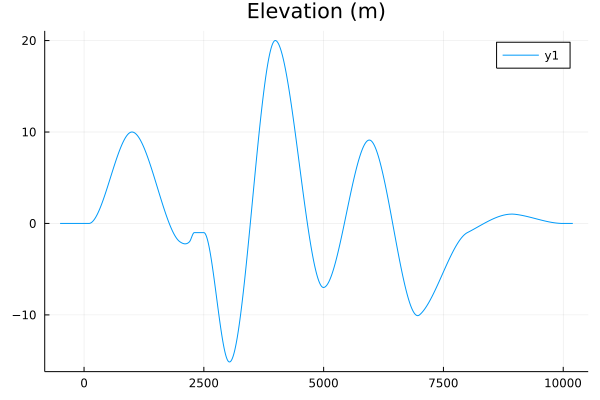

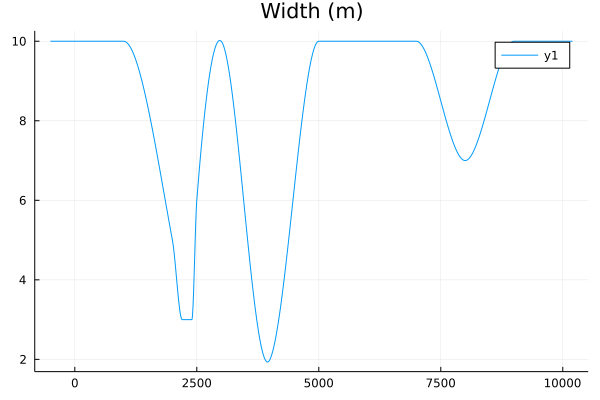

In [9]:
function plot_diff_track(track)
    xs = range(start=minimum(track.x_data), stop=maximum(track.x_data), length=1000)
    ys=track.cspline_elev(xs)
    display(plot(xs, ys,title="Elevation (m)",reuse=false))
end

function plot_width_track(track)
    xs = range(start=minimum(track.x_data), stop=maximum(track.x_data), length=1000)
    ys=track.cspline_width(xs)
    display(plot(xs, ys,reuse=false, title="Width (m)"))

end

plot_diff_track(track)
plot_width_track(track)

## Processing waves distribution and setting the speed profiles for the runners

### Descricao???

In [ ]:
TimeBins=[i for i in 30:100];
ReactionLineTime=parameters.timestep

RunnerDist=[15,18,20,17,18,18,31,40,45,72,96,88,109,131,155,192,
            207,270,281,263,326,298,268,240,309,296,346,313,323,347,
            286,325,281,274,291,252 ,285,220,220,207,213,180,172,145,140,
            151,112,145,96,85,85,87,85,73,42,47,27,39,45,31,28,29,24,21,15,21,14,17,14,12,12]

AcumulatedRelativeRunnerDist=cumsum(RunnerDist/sum(RunnerDist));

### Inverse distribution for avg times??? function setting the profiles and initial Como se chama isto?

In [ ]:
function inversepseudosigmoid( )
    par=parameters
    ldist=par.ldist
    nrunners=Int(par.nrunners)
    nwaves=par.numberofwaves
    mixwaves=Int.(par.waves[:,1:nwaves])
    wavedelays=par.waves[:,nwaves+1]
    waveinitspeeds=par.waves[:,nwaves+2]

    partitions=zeros(Float32,size(mixwaves)[1]+1)
    for part in range(1,nwaves)
        partitions[part+1]=partitions[part]+sum(mixwaves[:,part])/nrunners
    end

    println(">Control PreProcessing: partitions ", partitions)
    println(">Control PreProcessing: number of waves",  nwaves)

    waves=zeros(Float32,nrunners)
    wb=1
    we=1

    for wave in range(1, nwaves)
        parts=zeros(Float32,sum(mixwaves[wave, 1 : nwaves]))
        pb=1
        pe=1
        for part in range(1, nwaves)
            size=mixwaves[wave,part]
            pe+=size
            wavepart=rand(Uniform(partitions[part],partitions[part+1]),size)
            parts[pb:pe-1]=wavepart
            pb=pe
        end
        we+=size(parts)[1]
        shuffle!(parts) #mix parts in each wave
        waves[wb:we-1]=parts
        wb=we
    end

    RandDist=waves
    AvgTimes=CubicSpline(AcumulatedRelativeRunnerDist,TimeBins,  extrapl=[1, ], extrapr=[1, ])[RandDist]

    InitPositions=zeros(Float32,nrunners)
    WaveDelays=zeros(Float32,nrunners)
    WaveInitSpeeds=zeros(Float32,nrunners)
    SlopeFactors=rand(Uniform(-13.0,-3.0),nrunners)

    # Position along the start line
    NinWaves=Int.(zeros(Float32,nwaves))
    for wave in range(1,nwaves)
        NinWaves[wave]=sum(mixwaves[wave, 1: nwaves])
    end


    itemcount=0
    for (nwave,nrunners) in enumerate(NinWaves)
        linecounter=0
        for i in range(1,nrunners)
            # To avoid truncations due to the cubic spline
            auxwidthcontrl=Int(floor(track.cspline_width(-linecounter*ldist)+0.5))

            if (i+1)%auxwidthcontrl==0
                linecounter+=1
            end
            InitPositions[i+itemcount]=-linecounter*ldist#+0.30*np.random.random_sample()-0.15
            WaveDelays[i+itemcount]=wavedelays[nwave]+linecounter*ReactionLineTime
            WaveInitSpeeds[i+itemcount]=waveinitspeeds[nwave]
        end
        itemcount+=nrunners
    end

    return AvgTimes, RandDist, NinWaves,InitPositions, WaveDelays,WaveInitSpeeds,SlopeFactors
end;


## Setting the speed profiles, initial positions, etc 

In [ ]:
AvgTimes, RandDist,NinWaves,InitPositions, WaveDelays,WaveInitSpeeds, SlopeFactors= inversepseudosigmoid();

### Scatter plot of the times distributions accordingly to the wave mixtures 

In [ ]:
plot(AcumulatedRelativeRunnerDist,CubicSpline(AcumulatedRelativeRunnerDist,TimeBins,
        extrapl=[1, ], extrapr=[1, ])[AcumulatedRelativeRunnerDist],linecolor = :red,lw=2)
plot!(RandDist,sort(AvgTimes),seriestype = :scatter,title="Random Times Distribution",
    markersize=0.3,markeralpha = 0.4,markercolor = :blue )

### Defining a structure for each runner data 

In [ ]:
struct Frunner
    time::Float32
    wavedelay::Float32
    waveinitspeed::Float32
    initposition::Float32
    slopefactor::Float32

    avgspeed::Float32
    pos::Vector{Float32}
    vels::Vector{Float32}
    rhos::Vector{Float32}
end

In [ ]:
avgspeed(time)=(10000.0/(time*60.0));

In [ ]:
function pos(initposition)
    aux=zeros(parameters.observernsteps)
    aux[1]=initposition
    return aux
end;

In [ ]:
vels=zeros(parameters.observernsteps)
rhos=zeros(parameters.observernsteps);

In [ ]:
Frunner(time,wavedelay,waveinitspeed,initposition,slopefactor)=
Frunner(time,wavedelay,waveinitspeed,initposition,slopefactor,
        avgspeed(time),pos(initposition),vels,rhos);

## Runners structure (container for all data)

In [ ]:
mutable struct Runners
    group::Vector{Main.Frunner}
    nrunners::Int16

    pos::Matrix{Float32} 
    vels::Matrix{Float32}
    rhos::Matrix{Float32}

    wavedelays::Vector{Float32}
    waveinitspeeds::Vector{Float32}
    avgspeeds::Vector{Float32}
    slopefactors::Vector{Float32}
end

In [ ]:
positions(group)=reduce(hcat,[runner.pos for runner in group])' # ' = transpose
velocities(group)=reduce(hcat,[runner.vels for runner in group])'
rhosall(group)=reduce(hcat,[runner.rhos for runner in group])'
wavedelays(group)=[runner.wavedelay for runner in group]
waveinitspeeds(group)=[runner.waveinitspeed for runner in group]
avgspeeds(group)=[runner.avgspeed for runner in group]
slopefactors(group)=[runner.slopefactor for runner in group];

In [ ]:
Runners(group)=Runners(group,
                       nrunners,
                       positions(group),
                       velocities(group),
                       rhosall(group),
                       wavedelays(group),
                       waveinitspeeds(group),
                       avgspeeds(group),
                       slopefactors(group));

## Function for Rho and Group Speed (VL) computation

In [ ]:
function RhoVL(R::Vector{Float32},VL::Vector{Float32},X::Vector{Float32},V::Vector{Float32},
               allrunners::Main.Runners,
               par::Main.Parameters,
               track::Main.Tracks,training::Bool)
    nrunners=allrunners.nrunners
    minrho=par.minrho
    maxrho=par.maxrho
    minratio=par.minratio
    maxratio=par.maxratio
    racedistance=par.racedistance
    fvdist=par.frontviewdistance
    # sorted indexes of  the runners
    sortedargs=sortperm(X)
    # rho definition (density container)
    #For VL calculation. average of the  slowest in front of the runner
    foresightarea=zeros(Float32,nrunners)

    # First step: counting the number of runner in the frontview  area
     for (arg_idx, arg) in enumerate(sortedargs)
        if X[arg]< 0.0 continue end #start counting only after crossing the starting line
        if X[arg] > racedistance - fvdist continue end #stop near the crossing the finish line
        foresightarea[arg]=track.foresightarea_data[ceil(Int,X[arg])+1]
        #minn rf is the minimum number of runners in the foresight that impacts the runners speed

        minn=floor(Int, minratio*foresightarea[arg]) #min number of  runners for impact area
        maxn=floor(Int, maxratio*foresightarea[arg]) #min number of  runners for impact are
        #println(minn," ",maxn)
        # continue conditions
        if minn<3 continue end #At least 3 runners in the impact area
        if arg_idx+minn>length(sortedargs) continue end
        if X[sortedargs[arg_idx+minn]]-X[arg]>= fvdist continue end

        rhocounter=1.0
        argsofguysinfront=sortedargs[arg_idx+1:min(arg_idx+maxn,nrunners)]
         for arg_i in argsofguysinfront
            if X[arg_i]-X[arg]>fvdist continue
            else rhocounter+=1.0
            end
        end

        if (rhocounter/foresightarea[arg])>maxratio
            R[arg]=maxrho
            #println(rho[arg])
        elseif ((rhocounter/foresightarea[arg]<=maxratio)
                && (rhocounter/foresightarea[arg]>=minratio))
            D_A=rhocounter/foresightarea[arg]
            R[arg]=(minrho*(D_A-maxratio)-maxrho*(D_A-minratio))/(minratio-maxratio)
            #println(rho[arg])
        end


        lngth=floor(Int,minn/2) #
        #if lngth <2 continue end
        sortedspeeds=sort(V[argsofguysinfront])
        slowersspeeds=sortedspeeds[1:lngth]
        slowersavgspeed=sum(slowersspeeds)/length(slowersspeeds)
        VL[arg]=min(slowersavgspeed,V[arg])
        ############################################################################
    end
    return R,VL
end



## Speed function F $(\frac{dx}{dt}=F)$

In [ ]:
# Speed function 
function F(t::Float32,X::Vector{Float32},V::Vector{Float32},
           allrunners::Main.Runners,
           par::Main.Parameters,
           track::Main.Tracks,training::Bool)
    ## Some alias to simplify
    spline=track.cspline_elev
    nrunners=allrunners.nrunners
    VL=zeros(Float32,nrunners)
    racedistance=par.racedistance
    epsm=100
    R=zeros(Float32,nrunners)

    if training==true
        # Race for timing reports
         for r in 1:nrunners
            # Stop epsm=100m after the finishing line
            if (t <= allrunners.wavedelays[r]) || (X[r]>=racedistance+epsm)
                V[r]=0.0
            else
                V[r]=(allrunners.avgspeeds[r] + gradient(spline,X[r],1)*allrunners.slopefactors[r])
            end
        end
    elseif training==false

        R, VL = RhoVL(R,VL,X,V,allrunners,par,track,training)

         for r in 1:nrunners
            if (t <= allrunners.wavedelays[r]) || (X[r]>=racedistance+epsm)
                V[r]=0.0
            elseif X[r]<0 # This Condition can be improved! (wave propagation in lanes)
                V[r]=min(allrunners.waveinitspeeds[r],allrunners.avgspeeds[r])
            else
                rspeed=(allrunners.avgspeeds[r]+gradient(spline,X[r],1)*allrunners.slopefactors[r])
                V[r]=(1.0-R[r])*rspeed+R[r]*VL[r]
            end
        end

    end
    return V, R
end;

## 2nd order Runge-Kutta solver 

In [ ]:
function rk2(allrunners::Main.Runners,
             parameters::Main.Parameters,
             track::Main.Tracks,training::Bool)
    println(">Control OdeSystemSolvers: Entering rk2_solver")

    nrunners=allrunners.nrunners
    obsnsteps=parameters.observernsteps
    obststep=parameters.observertimestep
    dt=parameters.timestep
    nsteps=ceil(Int,parameters.endtime/dt)
    println(">Control OdeSystemSolvers: total number of time steps = ", nsteps)
    avgspeeds=allrunners.avgspeeds
    slopefactors=allrunners.slopefactors

    println(">Control OdeSystemSolvers: number of runners = ", nrunners)
    # Container for the solutions
    times=zeros(Float32,obsnsteps)

    # Internal Copy of allrunners.positions
    positions=allrunners.pos
    println(">control OdeSystemSolvers: size(positions)= ", size(positions))
    println(">control OdeSystemSolvers: initial positions= ", positions[nrunners-10:nrunners,1])

    #println(typeof(positions))
    velocities=zeros(Float32,nrunners,obsnsteps)
    rhos=zeros(Float32,nrunners,obsnsteps)

    X1=positions[:,1] #rk Updated positions
    X0=positions[:,1] #rk old positions
    V=velocities[:,1] # useless since it is 0

    K1=zeros(Float32,nrunners)
    K2=zeros(Float32,nrunners)
    R =zeros(Float32,nrunners)
    #k3=zeros(nrunners)
    #k4=zeros(nrunners)
    j=0
    for i in 0:(nsteps-1)
        t=dt*i
        V, R = F(t,X0, V, allrunners,parameters,track,training) #update velocities
        K1=dt .* V
        V, R = F(t+dt, X0 .+ K1, V,  allrunners,parameters,track,training) #update velocities
        K2=dt .* V
        X1=X0 .+ 0.5 .* (K1 .+ K2) # update positions

        ## Containers for Observer
        if ((i+1)*dt>=(obststep*j) && i*dt<=(obststep*j))
            delta=(j*obststep-i*dt)/dt
            beta=1.0-delta
            times[j+1]=obststep*(j+1)
            ## interpolations
            positions[:,j+1]= beta .* X0 .+ delta .*X1
            velocities[:,j+1]=V #beta .* velocities[:,j] .+delta.* V
            rhos[:,j+1]=R #beta .* rhos[:,j] .+ delta .* R
            if (j+1 == obsnsteps) break end
            j+=1
        end
        X0[:] .= X1[:]
    end

    return times, positions,velocities, rhos
end;
solver=rk2

## Race processing function

In [ ]:
function race(training::Bool)
    if training==false 
        strng="Race"
    else strng="Training"
    end
    
    println(">control $strng: model")
    runnerslist=Array{Frunner,1}(undef, nrunners)
    for i in 1:nrunners
        runnerslist[i]=Frunner(AvgTimes[i],WaveDelays[i],WaveInitSpeeds[i],InitPositions[i],SlopeFactors[i])
    end
    allrunners=Runners(runnerslist)
    println(">control $strng: sizes(allrunners.group)= ", size(allrunners.group))
    println(">control $strng: Pre-Processing done")
    println(">control $strng: Starting $strng Simulation")
    times, allrunners.pos, allrunners.vels, allrunners.rhos=solver(allrunners,parameters,track,training)
    println(">Control $strng: Processing done")
    return times, allrunners
end;

In [ ]:
training=true
t=@elapsed begin times ,alltrainees = race(training) end
println(">Elapsed time=", t)

In [ ]:
training=false
t=@elapsed begin times ,allrunners = race(training) end
println(">Elapsed time=", t)

## Post Processing functions

### Positions snapshot

In [ ]:
function snapshot(steps,allrunners,parameters,track,ninwaves)
    nrunners=allrunners.nrunners
    xs = range(start=minimum(track.x_data), stop=maximum(track.x_data), length=1000)
    ys=track.cspline_elev(xs)
    ws=track.cspline_width(xs)
    yws=ys .+ ws

    println("Control PostProcessing: number of snapshots ", length(steps))
    for step in steps
        time=Int(step*parameters.observertimestep)
        X=allrunners.pos[:, step]
        YWS=zeros(nrunners)
        for r in 1:nrunners
            YWS[r]=rand(Uniform(0,1))*track.cspline_width(X[r])+track.cspline_elev(X[r])
        end


        colors=["orange","cyan","green","purple","brown","pink","gray","azure","olive","blue"]
        nwaves=size(ninwaves)[1]


        plot(xs, ys,title="Race Snapshot t=$time (s)",label="Elevation")
        xlabel!("Track length (m)")
        ylabel!("Track elevation (m)")
        plot!(xs,yws,label="Width")
        wb=1
        we=0
        n=0
        for (color,counter) in zip(colors[1:nwaves],ninwaves)
            n+=1
            we+=counter
            plot!(X[wb:we],YWS[wb:we],seriestype = :scatter,
                  markersize=0.3,
                  markeralpha = 1.0,
                  markerstrokecolor =color,
                  label="wave $n")
            wb=we+1
        end
        display(plot!(size=(900,275))) 
        tm=lpad(time,4,"0")
        #savefig("./reports/pngs/snapshot$tm.png")
    end
end;


### Histogram snapshot

In [ ]:
function histsnapshot(steps,allrunners,parameters)
    println("Control PostProcessing: number of histsnapshots ", length(steps))
    for step in steps
        bins=0:round(Int,parameters.frontviewdistance):round(Int,parameters.racedistance)
        display(histogram(allrunners.pos[:,step],bins=bins,label=false,ylims=(0,100),size=(900,300)))
        xlabel!("Road (m)")
        ylabel!("Runners per 4 (m)")
        time=Int(step*parameters.observertimestep)
        tm=lpad(time,4,"0")
        #savefig("./reports/pngs/hist$tm.png")
    end
end;

### Speeds profiles

In [ ]:
function speedsvisuals(runnersidxs,allrunners,parameters,track)
    nrunners=allrunners.nrunners
    nsteps=parameters.observernsteps
    time=parameters.observertimestep*nsteps

    t=range(start=0.0,stop=time,length=nsteps)

    plot(title="Speed Profile")
    xlabel!("Time (s)")
    ylabel!("Speed (m/s)")

    for runner in runnersidxs #range(group.size):
        plot!(t,allrunners.vels[runner,:],lw=0.5,label=false)
    end
    plot!(size=(800,400))
    #savefig("./reports/pdfs/speeds_profile.pdf")
end;

### Phase (x=position,y=speed)

In [ ]:
function phasevisuals(runnersidxs,allrunners)
    plot(title="Phase Profile")
    xlabel!("Position (m)")
    ylabel!("Speed (m/s)")

    for runner in runnersidxs #range(group.size):
        plot!(allrunners.pos[runner,:],allrunners.vels[runner,:],lw=0.5,label="")
    end
    plot!(size=(800,400))
    #savefig("./reports/pdfs/Phases.pdf")
end

### Rho profiles

In [ ]:
function rhosvisuals(runnersidxs,allrunners)
    nrunners=allrunners.nrunners
    nsteps=parameters.observernsteps
    time=parameters.observertimestep*nsteps

    t=range(start=0.0,stop=time,length=nsteps)

    plot(title="Rho Profile")
    xlabel!("Time (s)")
    ylabel!("Rho")

    for runner in runnersidxs #range(group.size):
        plot!(t,allrunners.rhos[runner,:],lw=0.5,label="")
    end
    plot!(size=(800,400))
    #savefig("./reports/pdfs/rhos.pdf")
end;

## Post Processing

In [ ]:
snapshot([2000,4000],allrunners,parameters,track,NinWaves) 

In [ ]:
histsnapshot(1000,allrunners,parameters) 

In [ ]:
runnersidxs=rand(1:allrunners.nrunners,30)
speedsvisuals(runnersidxs,allrunners,parameters,track)

In [ ]:
phasevisuals(runnersidxs,allrunners)

In [ ]:
rhosvisuals(runnersidxs,allrunners)

## Function for race timing and metric reports/plots

In [ ]:
function timesvisuals(times,allrunners,allrunners_training,parameters)
    par=parameters
    nrunners=allrunners.nrunners
    starttimes=zeros(nrunners)
    endtimes=zeros(nrunners)

    for runner in 1:nrunners
        tsidx=findfirst(x->(x>0.0), allrunners.pos[runner,:])
        teidx=findfirst(x->(x>=par.racedistance),allrunners.pos[runner,:])
        starttimes[runner]=times[tsidx]
        endtimes[runner]=times[teidx]
    end

    println(">control Post-Processing: Waves=")
    println(par.waves)
    r0=1
    r1=sum(Int,par.waves[1, 1:par.numberofwaves])
    wave_departure=maximum(starttimes[r0:r1])
    wave_time_gap_to_cross=maximum(starttimes[r0:r1])-minimum(starttimes[r0:r1])+1
    println(">control Post-Processing: departures computation")
    println(">control Post-Processing: departures: wave: ",1, " departure:",  wave_departure)
    println(">control Post-Processing: departures: wave: ",1, " time gap to cross:",  wave_time_gap_to_cross)

    wavetxt=" ["*string(par.waves[1,1:size(par.waves)[1]])[9: end-1]*" ,0.0 ,"*string(par.waves[1,end])*"]"
    acumulated_wave_time_gap_to_cross=wave_time_gap_to_cross


    for j in range(2,size(par.waves)[1])
        r0+=sum(Int,par.waves[j-1, 1: par.numberofwaves])
        r1=r0+sum(Int,par.waves[j,1: par.numberofwaves])-1
        wave_departure=maximum(starttimes[r0:r1])
        wavetxt*="\n ["*string(par.waves[j,1:size(par.waves)[1]])[9:end-1]*","*string(acumulated_wave_time_gap_to_cross)*
        " + "*string(j-1)*"*gap ,"*string(par.waves[j,end])*"]"
        wave_time_gap_to_cross=maximum(starttimes[r0:r1])-minimum(starttimes[r0:r1])+1
        acumulated_wave_time_gap_to_cross+=wave_time_gap_to_cross
        println(">control Post-Processing: departures: wave: ",j, " departure:",  wave_departure)
        println(">control Post-Processing: departures: wave: ",j, " time gap to cross: ",  wave_time_gap_to_cross)
    end

    println(">control Post-Processing: suggested setting for waves after initial running for tune settings")
    println(">control Post-Processing: ********************************************************")
    println(wavetxt)
    println(">control Post-Processing: *********************************************************")


    runnertimes=endtimes-starttimes
    racetime=maximum(endtimes)
    slowrunners=argmax(endtimes)
    mintime=minimum(runnertimes)
    worsttime=maximum(runnertimes)
    winrunners=argmin(runnertimes)
    losrunners=argmax(runnertimes)

    starttimes_training=zeros(nrunners)
    endtimes_training=zeros(nrunners)


    for runner in 1:nrunners
        tsidx=findfirst(x->(x>0.0), allrunners_training.pos[runner,:])
        teidx=findfirst(x->(x>=par.racedistance),allrunners_training.pos[runner,:])
        starttimes_training[runner]=times[tsidx]
        endtimes_training[runner]=times[teidx]
    end

    runnertimes_training=endtimes_training-starttimes_training


    plot(1:nrunners,runnertimes,ms=0.8,label="Race",seriestype = :scatter,
         #markersize=0.5,
         #markeralpha = .5,
         markerstrokecolor = "orange",
         reuse=false)
    ylabel!("Time in seconds")
    xlabel!("Runner index")
    display(plot!(1:nrunners,runnertimes_training,ms=0.8,label="Training",seriestype = :scatter,
          #markersize=0.5,
         # markeralpha = 0.5,
         markerstrokecolor ="blue"))
   
    errors=runnertimes-runnertimes_training
    println(">control Post-Processing: departure: runners  affected by the velocity rule at departure ",
          length(findall(x->(x!=0.0),starttimes-starttimes_training)))
    println(">control Post-Processing: par.posweights=")
    println(par.posweights)


    t1=par.posweights[2,2]
    t2=par.posweights[3,2]
    t3=par.posweights[4,2]
    t4=par.posweights[5,2]

    w0=par.posweights[1,1]
    w1=par.posweights[2,1]
    w2=par.posweights[3,1]
    w3=par.posweights[4,1]
    w4=par.posweights[5,1]


    errorspen=zeros(length(errors))
    count_t1=0
    count_t2=0
    count_t3=0
    count_t4=0

    for (idx,error) in enumerate(errors)
        if error <= t1
            errorspen[idx]=error*w1
            count_t1+=1
        elseif t1 < error <= t2
            errorspen[idx]=w1*t1+(error-t1)*w2
            count_t2+=1
        elseif t2 < error <= t3
            errorspen[idx]=w1*t1+(t2-t1)*w2+(error-t2)*w3
            count_t3+=1
        else
            errorspen[idx]=w1*t1+(t2-t1)*w2+(t3-t2)*w3+(error-t3)*w4
            count_t4+=1
        end
    end
    println(">control Post-Processing: number of runners with time loss in [0,", t1,"] is ", count_t1)
    println(">control Post-Processing: number of runners with time loss in ]",t1,",", t2,"] is ", count_t2)
    println(">control Post-Processing: number of runners with time loss in ]",t2,",", t3,"] is ", count_t3)
    println(">control Post-Processing: number of runners with time loss > ",t3, " is ", count_t4)

    errorspen .+= w0 .* starttimes
    negerrors=findall(x->(x<0.0),errorspen)
    println(">control Post-Processing: waves description: errors computation for metric")
    r0=1
    r1=1
     for j in range(2,size(par.waves)[1])
         r0+=sum(Int,par.waves[j-1, 1:par.numberofwaves])
         r1=r0+sum(Int,par.waves[j, 1:par.numberofwaves])
         errorspen[r0:r1-1].-= w0.*par.waves[j,par.numberofwaves+1]
         println(">control Post-Processing:  wave ",
                 j-1, "start: ",r0," wave end: ",r1-1,", ",par.waves[j,par.numberofwaves+1])
     end


    println(">control Post-Processing: race time: ", racetime)
    println(">control Post-Processing: slowest racer: ", slowrunners)
    println(">control Post-Processing: best race time: ", mintime)
    println(">control Post-Processing: winner: ", winrunners)
    println(">control Post-Processing: worst race time: ", worsttime)
    println(">control Post-Processing: last: ", losrunners)

    metricerror=sum(errorspen)/length(errorspen)
    println(">control Post-Processing: metric error: ", metricerror)
    l1error=norm(errors,1)/length(errors)
    println(">control Post-Processing:  l1 error: ", l1error)


    plot(1:nrunners,errors,ms=0.5,label="Time lost",seriestype = :scatter, markerstrokecolor = "orange",
         title="Averaged time and metric losses = "*
         string(round(Int,l1error))*", "
         *string(round(Int,metricerror)),reuse=false)
    ylabel!("Time in seconds (total race time: "*string(ceil(Int,racetime))*")")
    xlabel!("Runner index")
    display(plot!(1:nrunners,errorspen,ms=0.5,label="Metric score",seriestype = :scatter, markerstrokecolor = "blue",))

end;

### Produce the reports

In [ ]:
timesvisuals(times,allrunners,alltrainees,parameters)